In [1]:
# Test interpolation methods

In [2]:
import xarray as xr
from pivpy import io, pivpy, graphics
import numpy as np

In [3]:
ds = io.create_sample_Dataset(n_frames=1,rows=7,cols=11,noise_sigma=0.5)

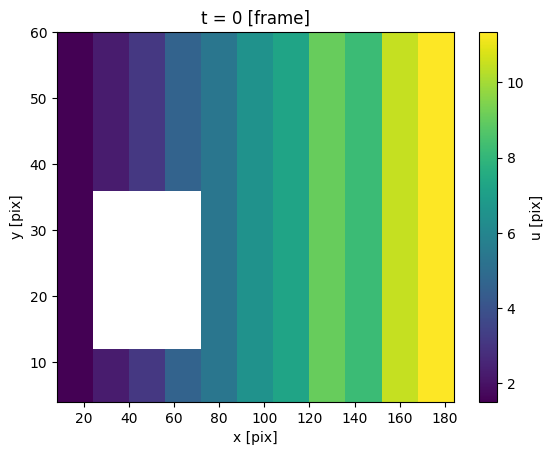

In [4]:
ds["u"][1:4,1:4] = np.nan
ds.sel(t=0)["u"].plot()

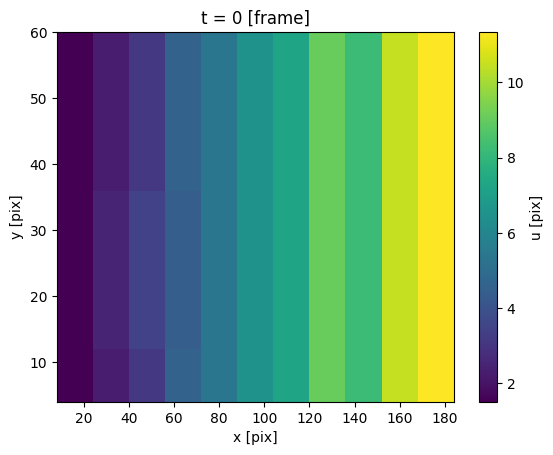

In [5]:
# see https://docs.xarray.dev/en/stable/user-guide/interpolation.html#interpolating-arrays-with-nan
filled = ds.copy()
filled["u"] = ds["u"].interpolate_na(dim=("x"),method='linear')
filled["u"] = filled["u"].interpolate_na(dim=("y"),method='linear')
filled.sel(t=0)["u"].plot()

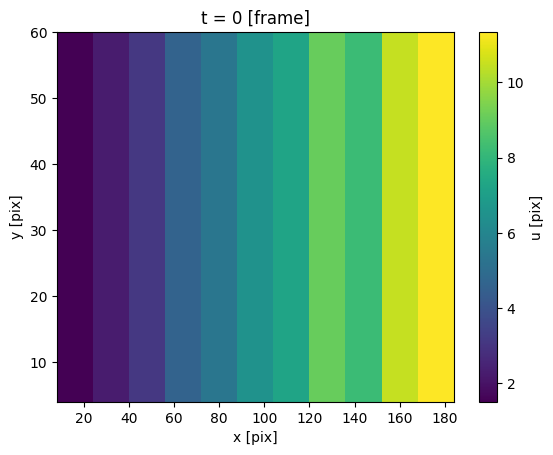

In [6]:
filled_ds = ds.copy()
filled["u"] = ds["u"].interpolate_na(dim=("y"),method='nearest')
filled["u"] = filled["u"].interpolate_na(dim=("x"),method='nearest')
filled.sel(t=0)["u"].plot()

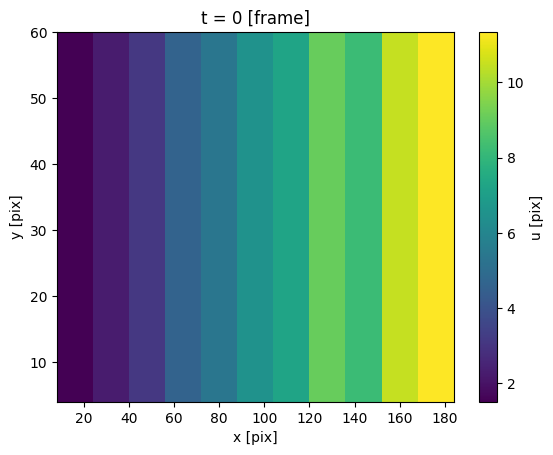

In [7]:
filled_ds = ds.copy()
filled["u"] = ds["u"].interpolate_na(dim=("y"),method='nearest')
filled["u"] = filled["u"].interpolate_na(dim=("x"),method='nearest')
filled.sel(t=0)["u"].plot()

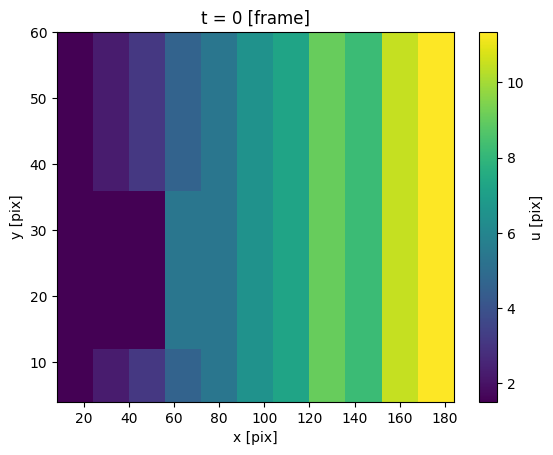

In [8]:
filled_ds = ds.copy()
filled["u"] = ds["u"].interpolate_na(dim=("x"),method='nearest')
filled["u"] = filled["u"].interpolate_na(dim=("y"),method='nearest')
filled.sel(t=0)["u"].plot()

## obviously 1d Interpolator does not work, if we do not know which direction to interpolate

In [9]:
## Option 1: use rioxarray idea for griddata 

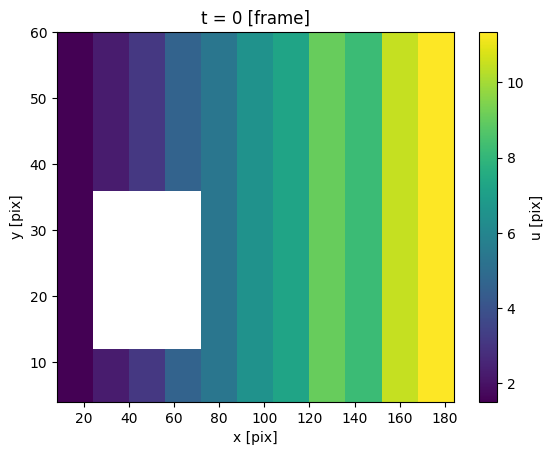

In [10]:
ds["u"].plot()

In [11]:
# we should learn how to use xarray.apply_ufunc
# follow https://docs.xarray.dev/en/stable/examples/apply_ufunc_vectorize_1d.html

In [12]:
new = ds.copy(deep=True) # note the deep feature, otherwise, underlying data is overwritten

In [13]:
new.piv.fill_nans()

<xarray.Dataset> Size: 2kB
Dimensions:  (y: 7, x: 11, t: 1)
Coordinates:
  * x        (x) int64 88B 16 32 48 64 80 96 112 128 144 160 176
  * y        (y) int64 56B 8 16 24 32 40 48 56
  * t        (t) int64 8B 0
Data variables:
    u        (y, x, t) float64 616B 1.506 2.251 3.113 ... 8.199 10.48 11.34
    v        (y, x, t) float64 616B -0.6187 -0.6187 -0.6187 ... 1.365 1.365
    chc      (y, x, t) float64 616B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes: (2)

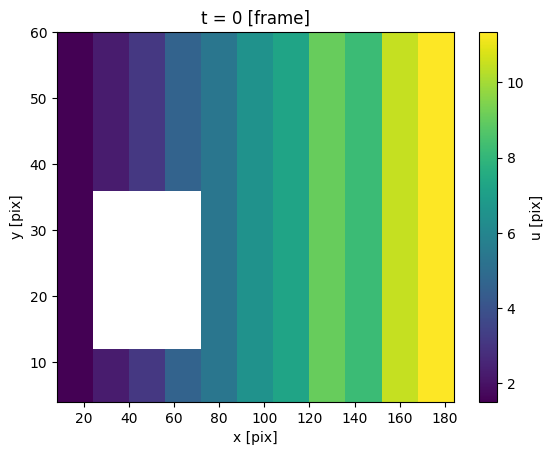

In [14]:
ds["u"].plot()

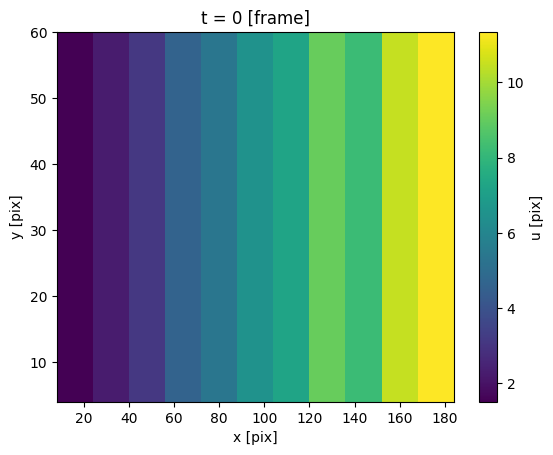

In [15]:
new["u"].plot()

In [16]:
### Additional ideas for small holes

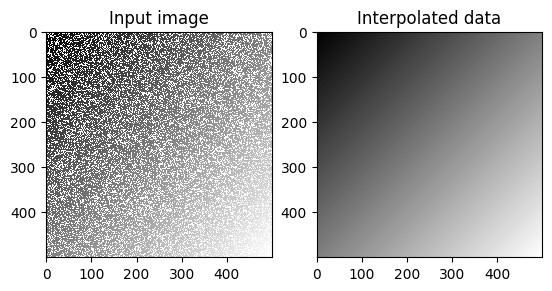

In [17]:
# from  https://bitcoden.com/answers/numpy-inpaint-nans-interpolate-and-extrapolate

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

x = np.linspace(0, 1, 500)
y = x[:, None]
image = x + y

# Destroy some values
mask = np.random.random(image.shape) > 0.7
image[mask] = np.nan

# valid_mask = ~np.isnan(image)
# coords = np.array(np.nonzero(valid_mask)).T
# values = image[valid_mask]

# it = interpolate.LinearNDInterpolator(coords, values, fill_value=0)

# filled = it(list(np.ndindex(image.shape))).reshape(image.shape)

# f, (ax0, ax1) = plt.subplots(1, 2)

# ax0.imshow(image, cmap='gray', interpolation='nearest')
# ax0.set_title('Input image')
# ax1.imshow(filled, cmap='gray', interpolation='nearest')
# ax1.set_title('Interpolated data')
# plt.show()


ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans

import scipy
def inpaint_nans(im):
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = scipy.signal.convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = scipy.signal.convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im


f, (ax0, ax1) = plt.subplots(1, 2)

ax0.imshow(image, cmap='gray', interpolation='nearest')
ax0.set_title('Input image')
ax1.imshow(inpaint_nans(image), cmap='gray', interpolation='nearest')
ax1.set_title('Interpolated data')
plt.show()

In [18]:
ds.dropna(dim='x')["v"].shape

(7, 8, 1)

In [19]:
new.dropna(dim='x')["v"].shape

(7, 11, 1)

In [20]:
assert new.dropna(dim='t') == new